In [1]:
!pip install sortedcontainers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import string

from abc import ABC, abstractmethod
from math import log2, sqrt
from collections import Counter

from tqdm import tqdm

from nltk import bigrams, word_tokenize
from sortedcontainers import SortedListWithKey

In [16]:
class LanguageModel:
    def __init__(self, ngram_size=2, lowercase=False):
        """
            Initialization of N-gram model
            :param ngram_size: size of n-gram, optional
        """

        if ngram_size < 2:
            raise Exception

        self.ngram_size = ngram_size

        self.unigram_counts = Counter()
        self.bigram_counts = Counter()

        #self.first_from_bigram_counts = Counter()
        #self.last_from_bigram_counts = Counter()

        self.words_set_size = None
        self.n_tokens = None
        self.lowercase = lowercase

    def fit(self, data):
        """
            Training of the model on texts
            :param data: sentences list
        """

        for text in tqdm(data, total=len(data)):

          if self.lowercase:
              text = text.lower()

          tokens = word_tokenize(text)

          self.words_set_size = len(set(tokens))
          self.n_tokens = len(tokens)

          self.unigram_counts += Counter(tokens)
          self.bigram_counts += Counter(bigrams(tokens))

        #for bigram, counts in tqdm(self.bigram_counts.items(), total=len(self.bigram_counts)):
        #    self.first_from_bigram_counts[bigram[0]] += counts
        #    self.last_from_bigram_counts[bigram[-1]] += counts
        return self
    
    def get_vocab_size(self):
        return self.words_set_size

    def get_n_tokens(self):
      return self.n_tokens
    
    def get_unigrams(self):
        return self.unigram_counts
    
    def get_bigrams(self):
        return self.bigram_counts

    def get_first_words_of_bigrams(self):
        return self.first_from_bigram_counts

    def get_last_words_of_bigrams(self):
        return self.last_from_bigram_counts

#### Pointwise Mutual Information

 $$PMI(w_1, w_2) = \log_2{\frac{P(w_1,w_2)}{P(w_1)P(w_2)}}$$

$$P(W) = \frac{freq(w)}{totalWordsCount}$$

#### T-Score

$$t = \frac{\overline{x} - \mu}{\frac{s}{\sqrt{n}}}$$

Здесь предполагается, что биграмма $(x, y)$ сгенерирована из распределения Бернулли с вероятностью $p$.

Матожидание $\mu = p$, а дисперсия $\sigma^2 = p(1-p)$. Поскольку $p$ достаточно мало, то для большинства биграмм $\sigma^2 \approx p$.

Определим гипотезу $H_0$: вероятность биграммы равна произведению вероятностей отдельных слов. Альтернативная гипотеза $H_1$: вероятности не равны.

Тогда мы можем посчитать величину $t$. Чем больше величина $t$, тем больше вероятность того, что мы отвергнем основную гипотезу $H_0$.

$\chi^2$-test

$$\chi_c ^2 = \sum\limits_i \frac{(O_i - E_i)^2}{E_i}$$

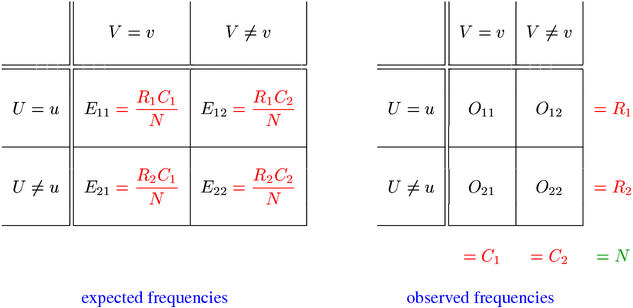

#### Dice Coefficient

$$DICE(x, y)=\frac{2 c(x, y)}{c(x) c(y)}$$

Другие формулы и идеи: http://mlwiki.org/index.php/Collocation_Extraction

In [12]:
class Metric(ABC):
    @abstractmethod
    def evaluate(self, freq_w1, freq_w2, freq_w12, vocab_size):
        pass


class ChiSquareScore(Metric):
    def evaluate(self, freq_w1, freq_w2, freq_w12, vocab_size):
        pass

    def evaluate_(self, freq_w12, freq_nw1w2, freq_w1nw2, freq_nw1nw2):
        """
        Напишите формулу для вычисления критерия X^2
        """
        a, b, c, d = freq_w12, freq_nw1w2, freq_w1nw2, freq_nw1nw2
        N = freq_w12 + freq_w1nw2 + freq_nw1w2 + freq_nw1nw2
        
        return N * ((a * d - b * c) ^ 2) / ((a + b) * (a + c) * (b + d) * (c + d))


class PMI(Metric):
    def evaluate(self, freq_w1, freq_w2, freq_w12, vocab_size):
        """
        Напишите формулу для поточечной взаимной информации
        """
        p_w1 = freq_w1 / vocab_size
        p_w2 = freq_w2 / vocab_size
        p_w12 = (freq_w12 + 1) / (freq_w1 + vocab_size)
        return log2(p_w12 / (p_w1 * p_w2))


class TScore(Metric):
    def evaluate(self, freq_w1, freq_w2, freq_w12, vocab_size):
        """
        Напишите формулу для t-теста
        """
        p_w1 = freq_w1 / vocab_size
        p_w2 = freq_w2 / vocab_size
        p_w12 = (freq_w12 + 1) / (freq_w1 + vocab_size)
        diff = p_w12 - p_w1 * p_w2
        s = p_w12 * (1 - p_w12)
        return diff / sqrt(s / vocab_size)


class Dice(Metric):
    def evaluate(self, freq_w1, freq_w2, freq_w12, vocab_size):
        """
        Напишите формулу для коэффициента DICE
        """
        return (2 * freq_w12) / (freq_w1 + freq_w2)

In [29]:
class CollocationExtractor:
    CONJ_RU = set('и а да но если б бы'.split())
    PROPOSITIONS_RU = set('с со на из за в во к ко по про о у об обо под подо над надо от до после'.split())
    PRONOUNS_RU = set('мне тебе мой моя моё мной я мы ты тобой тобою вы он она оно они те эти это этот тот та той ту ней ним'.split())
    PUNCT = set(string.punctuation) | {'--', '...'}
    INITIALS = re.compile(r'^[а-яa-z]\.$', re.I)

    def __init__(self, lm, exclude_punctuation=True, exclude_conj=True, exclude_props=True):
        self.language_model = lm
        self.exclude_punctuation = exclude_punctuation
        self.exclude_conj = exclude_conj
        self.exclude_props = exclude_props

    def extract_collocations(self, metric_class):
        """
        Напишите функцию, которая будет извлекать коллокации по полученной языковой модели.
        :param metric_class: класс конкретной метрики, по которой считается значимость коллокации
        :return collocations отсортированный список колокаций со значениями 
        # (значение_метрики, частота_w1, частота_w2, частота_биграммы, w1, w2)
        """
        assert issubclass(metric_class, Metric)
        metric = metric_class()
        collocations = SortedListWithKey(key=lambda x: -x[0])
        
        unigram_counts = self.language_model.get_unigrams()
        bigram_counts = self.language_model.get_bigrams()

        N = sum(bigram_counts.values())

        for (first, last), freq_bigram in tqdm(bigram_counts.items(), total=len(bigram_counts)):

            if self.exclude_punctuation:
                if first in self.PUNCT or last in self.PUNCT or \
                        self.INITIALS.match(first) or self.INITIALS.match(last):
                    continue

            if self.exclude_conj:
                if first in self.CONJ_RU or last in self.CONJ_RU:
                    continue

            if self.exclude_props:
                if first in self.PROPOSITIONS_RU | self.PRONOUNS_RU or \
                last in self.PROPOSITIONS_RU | self.PRONOUNS_RU:
                    continue

            freq_first, freq_last = unigram_counts[first], unigram_counts[last]

            if isinstance(metric, ChiSquareScore):
                a = freq_bigram
                b = freq_last - freq_bigram
                c = freq_first - freq_bigram
                d = N - (a + b + c)
                metric_val = metric.evaluate_(a, b, c, d)
            else:
                metric_val = metric.evaluate(freq_first, freq_last, freq_bigram,
                                         self.language_model.get_vocab_size())
            collocations.add((metric_val, freq_first,
                              freq_last, freq_bigram,
                              first, last))
        return collocations

In [6]:
fname = "/content/Dostoevsky.txt"
with open(fname, 'r', encoding='utf-8') as fin:
    data = ['^ ' + line.strip() + ' $' for line in fin.readlines() if not line.isspace()]

In [7]:
data[:5]

['^ Федор Михайлович Достоевский $',
 '^ Бедные люди $',
 '^ РОМАН $',
 '^ Ох уж эти мне сказочники! $',
 '^ Нет чтобы написать что-нибудь полезное, приятное, усладительное, а то всю подноготную в земле вырывают!.. $']

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
model = LanguageModel(lowercase=True)
model.fit(data)

100%|██████████| 478281/478281 [00:00<00:00, 606148.19it/s]


In [30]:
collocations_extractor = CollocationExtractor(lm=model)

In [19]:
TOPN = 100

In [20]:
print("Mutual Information results...")
collocations_list = collocations_extractor.extract_collocations(PMI)
for collocation in collocations_list[:TOPN]:
    print(collocation)

Mutual Information results...


100%|██████████| 478281/478281 [00:03<00:00, 131004.15it/s]

(6.088641032447621, 1, 1, 1, 'миловидного', 'личика-то')
(6.088641032447621, 1, 1, 1, 'весенними', 'ароматами')
(6.088641032447621, 1, 1, 1, 'птичкой', 'небесной')
(6.088641032447621, 1, 1, 1, 'пунсовые', 'крестиками')
(6.088641032447621, 1, 1, 1, 'аршинных', 'спицах')
(6.088641032447621, 1, 1, 1, 'подопрет', 'ручонкой')
(6.088641032447621, 1, 1, 1, 'ручонкой', 'розовую')
(6.088641032447621, 1, 1, 1, 'розовую', 'щечку')
(6.088641032447621, 1, 1, 1, 'покорнейшею', 'услужницей')
(6.088641032447621, 1, 1, 1, 'шкафы', 'поломанные')
(6.088641032447621, 1, 1, 1, 'яичною', 'скорлупою')
(6.088641032447621, 1, 1, 1, 'рыбьими', 'пузырями')
(6.088641032447621, 1, 1, 1, 'тульским', 'заседателем')
(6.088641032447621, 1, 1, 1, 'благорастворение', 'воздухов')
(6.088641032447621, 1, 1, 1, 'воздадим', 'благодарение')
(6.088641032447621, 1, 1, 1, 'крикливые', 'стаи')
(6.088641032447621, 1, 1, 1, 'лютом', 'жребии')
(6.088641032447621, 1, 1, 1, 'поминутного', 'болтания')
(6.088641032447621, 1, 1, 1, 'саше

In [21]:
print("T-Score results...")
collocations_list = collocations_extractor.extract_collocations(TScore)
for collocation in collocations_list[:TOPN]:
    print(collocation)

T-Score results...


100%|██████████| 478281/478281 [00:04<00:00, 102060.22it/s]

(2.222320186052034, 6, 6, 6, 'мистером', 'астлеем')
(2.222320186052034, 6, 6, 6, 'авдотью', 'романовну')
(2.1471212742162913, 5, 5, 5, 'авдотьей', 'романовной')
(2.1471212742162913, 5, 5, 5, 'степане', 'трофимовиче')
(2.1471212742162913, 5, 5, 5, 'арины', 'прохоровны')
(2.1289061670293923, 10, 11, 10, 'смертном', 'одре')
(2.101482469931303, 7, 6, 6, 'cinq', 'sous')
(2.039575132766401, 6, 5, 5, 'mille', 'francs')
(2.0375821047202605, 4, 4, 4, 'никодиму', 'фомичу')
(2.0375821047202605, 4, 4, 4, 'премудрый', 'змий')
(1.9440101192141028, 5, 4, 4, 'бараний', 'рог')
(1.9440101192141028, 5, 4, 4, 'алексеем', 'нилычем')
(1.8875688432170428, 3, 3, 3, 'ноев', 'ковчег')
(1.8875688432170428, 3, 3, 3, 'синильная', 'кислота')
(1.8875688432170428, 3, 3, 3, 'стопки', 'паньски')
(1.8875688432170428, 3, 3, 3, 'никодимом', 'фомичом')
(1.8875688432170428, 3, 3, 3, 'благим', 'матом')
(1.8875688432170428, 3, 3, 3, 'toutes', 'lettres')
(1.8875688432170428, 3, 3, 3, 'морген', 'фри')
(1.8875688432170428, 3, 3,

In [22]:
model.get_unigrams()['часочек-другой'], model.get_bigrams()[('часочек-другой', 'люблю')]

(1, 1)

In [23]:
model.get_unigrams()['что-то'], sum(1 for t in model.get_bigrams() if t[0] == 'что-то')

(806, 402)

In [26]:
model.get_first_words_of_bigrams()['что-то'], model.get_last_words_of_bigrams()['что-то']

(806, 806)

In [31]:
print("ChiSquare-Score results...")
collocations_list = collocations_extractor.extract_collocations(ChiSquareScore)
for collocation in collocations_list[:TOPN]:
    print(collocation)

ChiSquare-Score results...


100%|██████████| 478281/478281 [00:04<00:00, 102406.60it/s]


(1.0000022060115776, 1, 1, 1, 'миловидного', 'личика-то')
(1.0000022060115776, 1, 1, 1, 'весенними', 'ароматами')
(1.0000022060115776, 1, 1, 1, 'птичкой', 'небесной')
(1.0000022060115776, 1, 1, 1, 'пунсовые', 'крестиками')
(1.0000022060115776, 1, 1, 1, 'аршинных', 'спицах')
(1.0000022060115776, 1, 1, 1, 'подопрет', 'ручонкой')
(1.0000022060115776, 1, 1, 1, 'ручонкой', 'розовую')
(1.0000022060115776, 1, 1, 1, 'розовую', 'щечку')
(1.0000022060115776, 1, 1, 1, 'покорнейшею', 'услужницей')
(1.0000022060115776, 1, 1, 1, 'шкафы', 'поломанные')
(1.0000022060115776, 1, 1, 1, 'яичною', 'скорлупою')
(1.0000022060115776, 1, 1, 1, 'рыбьими', 'пузырями')
(1.0000022060115776, 1, 1, 1, 'тульским', 'заседателем')
(1.0000022060115776, 1, 1, 1, 'благорастворение', 'воздухов')
(1.0000022060115776, 1, 1, 1, 'воздадим', 'благодарение')
(1.0000022060115776, 1, 1, 1, 'крикливые', 'стаи')
(1.0000022060115776, 1, 1, 1, 'лютом', 'жребии')
(1.0000022060115776, 1, 1, 1, 'поминутного', 'болтания')
(1.0000022060115

In [32]:
print("Dice results...")
collocations_list = collocations_extractor.extract_collocations(Dice)
for collocation in collocations_list[:TOPN]:
    print(collocation)

Dice results...


100%|██████████| 478281/478281 [00:04<00:00, 107046.75it/s]

(1.0, 1, 1, 1, 'миловидного', 'личика-то')
(1.0, 1, 1, 1, 'весенними', 'ароматами')
(1.0, 1, 1, 1, 'птичкой', 'небесной')
(1.0, 3, 3, 3, 'ноев', 'ковчег')
(1.0, 1, 1, 1, 'пунсовые', 'крестиками')
(1.0, 1, 1, 1, 'аршинных', 'спицах')
(1.0, 1, 1, 1, 'подопрет', 'ручонкой')
(1.0, 1, 1, 1, 'ручонкой', 'розовую')
(1.0, 1, 1, 1, 'розовую', 'щечку')
(1.0, 1, 1, 1, 'покорнейшею', 'услужницей')
(1.0, 1, 1, 1, 'шкафы', 'поломанные')
(1.0, 1, 1, 1, 'яичною', 'скорлупою')
(1.0, 1, 1, 1, 'рыбьими', 'пузырями')
(1.0, 1, 1, 1, 'тульским', 'заседателем')
(1.0, 1, 1, 1, 'благорастворение', 'воздухов')
(1.0, 1, 1, 1, 'воздадим', 'благодарение')
(1.0, 1, 1, 1, 'крикливые', 'стаи')
(1.0, 1, 1, 1, 'лютом', 'жребии')
(1.0, 1, 1, 1, 'поминутного', 'болтания')
(1.0, 1, 1, 1, 'саше', 'пряничных')
(1.0, 1, 1, 1, 'пряничных', 'петушков')
(1.0, 1, 1, 1, 'попавшийся', 'запыленный')
(1.0, 1, 1, 1, 'изъеденное', 'червями')
(1.0, 1, 1, 1, 'червями', 'латинское')
(1.0, 1, 1, 1, 'зноя', 'дневного')
(1.0, 1, 1, 1, 'обил